# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **Research Paper Summarization Engine** |

# II. Notebook Target Definition

This Jupyter Notebook is dedicated to the model training and evaluation phase of Research Paper Summarization Engine Project. Starting with a dataset that has undergone extensive Exploratory Data Analysis (EDA) and preprocessing in prior stages, this notebook ensures reproducibility by initializing a random seed before proceeding to tokenizer and data loader setup. We leverage the capabilities of pre-trained models, specifically T5 Small and PEGASUS, to establish a baseline for our summarization tasks. Subsequently, these models are fine-tuned using our curated dataset and specific configurations to enhance performance. The notebook concludes with a comprehensive performance review of the models, followed by the exportation of the newly optimized models for future application.

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, T5ForConditionalGeneration, T5Tokenizer
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
import torch

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if cuda_available:
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device name: NVIDIA GeForce GTX 1660 SUPER


## III.B. Import Data

In [3]:
train_df = pd.read_pickle('../../data/processed/train_df_processed.pkl')
test_df= pd.read_pickle('../../data/processed/test_df_processed.pkl')
validation_df = pd.read_pickle('../../data/processed/validation_df_processed.pkl')

In [4]:
train_df.head()

,source,target
0,Due to the success of deep learning to solving...,We provide necessary and sufficient analytical...
1,The backpropagation (BP) algorithm is often th...,"Biologically plausible learning algorithms, pa..."
2,"We introduce the 2-simplicial Transformer, an ...",We introduce the 2-simplicial Transformer and ...
3,"We present Tensor-Train RNN (TT-RNN), a novel ...",Accurate forecasting over very long time horiz...
4,Recent efforts on combining deep models with p...,We propose a variational message-passing algor...


In [5]:
test_df.head()

,source,target
0,Incremental class learning involves sequential...,"FearNet is a memory efficient neural-network, ..."
1,Multi-view learning can provide self-supervisi...,Multi-view learning improves unsupervised sent...
2,We show how discrete objects can be learnt in ...,We show how discrete objects can be learnt in ...
3,Most recent gains in visual recognition have o...,A large-scale dataset for training attention m...
4,"In recent years, deep neural networks have dem...",We proposed a time-efficient defense method ag...


In [6]:
validation_df.head()

,source,target
0,Mixed precision training (MPT) is becoming a p...,We devise adaptive loss scaling to improve mix...
1,"Many real-world problems, e.g. object detectio...",We present a novel approach for learning to pr...
2,Foveation is an important part of human vision...,We compare object recognition performance on i...
3,We explore the concept of co-design in the con...,We develop methods to train deep neural models...
4,Batch Normalization (BatchNorm) has shown to b...,Investigation of how BatchNorm causes adversar...


# IV. Models Training and Evaluation

## IV.A. Data Shape Inspection

In [7]:
train_df.shape, test_df.shape, validation_df.shape

((1991, 2), (618, 2), (618, 2))

## IV.B. Data Information Inspection

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1991 entries, 0 to 1991
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  1991 non-null   object
 1   target  1991 non-null   object
dtypes: object(2)
memory usage: 46.7+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  618 non-null    object
 1   target  618 non-null    object
dtypes: object(2)
memory usage: 9.8+ KB


In [10]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 0 to 618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  618 non-null    object
 1   target  618 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB


## IV.C. Models Training

### IV.C.1. Random Seed Initialization

In [11]:
def set_seed(seed_value=777):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
set_seed(777)

### IV.C.2. Tokenizer and Data Loader Initialization

In [13]:
class SummarizationDataset(Dataset):
    def __init__(self, tokenizer, text_list, summary_list, max_length=512):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for text, summary in zip(text_list, summary_list):
            encodings = tokenizer(
                text,
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )
            target_encodings = tokenizer(
                summary,
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )
            self.input_ids.append(encodings.input_ids)
            self.attn_masks.append(encodings.attention_mask)
            self.labels.append(target_encodings.input_ids)


    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx].flatten(),
            "attention_mask": self.attn_masks[idx].flatten(),
            "labels": self.labels[idx].flatten()
        }


    def __len__(self):
        return len(self.input_ids)


def prepare_data(tokenizer, dfs, batch_size):
    datasets = {
        split: SummarizationDataset(
            tokenizer,
            df["source"].tolist(),
            df["target"].tolist()
        ) for split, df in dfs.items()
    }
    loaders = {
        f"{split}_loader": DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=(split == "train")
        ) for split, dataset in datasets.items()
    }
    return loaders

In [14]:
dataframes = {
    "train": train_df,
    "test": test_df,
    "validation": validation_df
}

In [15]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=False)
t5_loaders = prepare_data(t5_tokenizer, dataframes, batch_size=16)
pegasus_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
pegasus_loaders = prepare_data(pegasus_tokenizer, dataframes, batch_size=1)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### IV.C.3. Load Pre-Trained Models

In [16]:
def initialize_model_and_optimizer(model_name, device, learning_rate):
    if model_name.startswith("t5"):
        model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    elif model_name.startswith("google/pegasus"):
        model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
    else:
        raise ValueError("Unsupported model. Please use 't5-small' or 'google/pegasus-xsum'.")
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    return model, optimizer


def train_and_evaluate(model, optimizer, device, train_loader, test_loader=None, epochs=3, accumulation_steps=4):
    model.to(device)
    scaler = GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    training_stats = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()
        progress_bar = tqdm(enumerate(train_loader, start=1), total=len(train_loader), desc=f"Epoch {epoch+1}", leave=True)
        for step, batch in progress_bar:
            with autocast():
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / accumulation_steps
            scaler.scale(loss).backward()
            if step % accumulation_steps == 0 or step == len(train_loader):
                scaler.unscale_(optimizer)
                clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            total_loss += loss.item()
            progress_bar.set_postfix({"loss": total_loss / (step + 1)})
        average_train_loss = total_loss / len(train_loader)
        training_stats.append({
            "epoch": epoch + 1,
            "Training Loss": average_train_loss,
        })
        print(f"Epoch {epoch+1} | Average Training Loss: {average_train_loss}")
        if test_loader:
            model.eval()
            test_loss = 0
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                with torch.no_grad():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    test_loss += loss.item()
            average_test_loss = test_loss / len(test_loader)
            training_stats[-1]["Test Loss"] = average_test_loss
            print(f"Epoch {epoch+1} | Test Loss: {average_test_loss}")
            scheduler.step(average_test_loss)
    plt.plot([stats["epoch"] for stats in training_stats], [stats["Training Loss"] for stats in training_stats], label="Training Loss")
    if "Test Loss" in training_stats[0]:
        plt.plot([stats["epoch"] for stats in training_stats], [stats["Test Loss"] for stats in training_stats], label="Test Loss")
    plt.title("Training & Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return training_stats

In [17]:
t5_model_name = 't5-small'
t5_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t5_learning_rate = 1e-4
t5_batch_size = 16
t5_model, t5_optimizer = initialize_model_and_optimizer(t5_model_name, t5_device, t5_learning_rate)

In [18]:
pegasus_model_name = 'google/pegasus-xsum'
pegasus_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pegasus_learning_rate = 1e-5
pegasus_batch_size = 1
pegasus_model, pegasus_optimizer = initialize_model_and_optimizer(pegasus_model_name, pegasus_device, pegasus_learning_rate)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### IV.C.4. Pre-Trained Models Trials

In [19]:
text_to_try_t5 = train_df["source"].iloc[0]
t5_input_ids_trial = t5_tokenizer.encode("Summarize: " + text_to_try_t5, return_tensors='pt').to(t5_device)
t5_summary_ids_trial = t5_model.generate(t5_input_ids_trial, max_length=200, min_length=30, length_penalty=1.5, num_beams=6, early_stopping=True)
t5_summary_trial = t5_tokenizer.decode(t5_summary_ids_trial[0], skip_special_tokens=True)

In [20]:
print("Original Text:", text_to_try_t5)
print("T5 Summary:", t5_summary_trial)

Original Text: Due to the success of deep learning to solving a variety of challenging machine learning tasks, there is a rising interest in understanding loss functions for training neural networks from a theoretical aspect. Particularly, the properties of critical points and the landscape around them are of importance to determine the convergence performance of optimization algorithms. In this paper, we provide a necessary and sufficient characterization of the analytical forms for the critical points (as well as global minimizers) of the square loss functions for linear neural networks. We show that the analytical forms of the critical points characterize the values of the corresponding loss functions as well as the necessary and sufficient conditions to achieve global minimum. Furthermore, we exploit the analytical forms of the critical points to characterize the landscape properties for the loss functions of linear neural networks and shallow ReLU networks. One particular conclusi

In [21]:
text_to_try_pegasus = train_df["source"].iloc[0]
pegasus_input_ids_trial = pegasus_tokenizer.encode(text_to_try_pegasus, return_tensors='pt').to(pegasus_device)
pegasus_summary_ids_trial = pegasus_model.generate(pegasus_input_ids_trial, max_length=200, min_length=30, length_penalty=1.5, num_beams=6, early_stopping=True)
pegasus_summary_trial = pegasus_tokenizer.decode(pegasus_summary_ids_trial[0], skip_special_tokens=True)

In [22]:
print("Original Text:", text_to_try_pegasus)
print("T5 Summary:", pegasus_summary_trial)

Original Text: Due to the success of deep learning to solving a variety of challenging machine learning tasks, there is a rising interest in understanding loss functions for training neural networks from a theoretical aspect. Particularly, the properties of critical points and the landscape around them are of importance to determine the convergence performance of optimization algorithms. In this paper, we provide a necessary and sufficient characterization of the analytical forms for the critical points (as well as global minimizers) of the square loss functions for linear neural networks. We show that the analytical forms of the critical points characterize the values of the corresponding loss functions as well as the necessary and sufficient conditions to achieve global minimum. Furthermore, we exploit the analytical forms of the critical points to characterize the landscape properties for the loss functions of linear neural networks and shallow ReLU networks. One particular conclusi

### IV.C.4. T5 Small Model Training

Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: 2.134976361989975
Epoch 1 | Test Loss: 1.0304231750659454


Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 | Average Training Loss: 0.07105777239799499
Epoch 2 | Test Loss: 0.7888292463926169


Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 | Average Training Loss: 0.047345642536878584
Epoch 3 | Test Loss: 0.7456071904072394


Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 | Average Training Loss: 0.04259622874855995
Epoch 4 | Test Loss: 0.7200293655578907


Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 | Average Training Loss: 0.04027019587159157
Epoch 5 | Test Loss: 0.7111017902692159


Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6 | Average Training Loss: 0.039075114727020265
Epoch 6 | Test Loss: 0.705634606954379


Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7 | Average Training Loss: 0.03815933261811733
Epoch 7 | Test Loss: 0.7010215986997653


Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8 | Average Training Loss: 0.03757098677754402
Epoch 8 | Test Loss: 0.7020608286062876


Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9 | Average Training Loss: 0.037005707666277886
Epoch 9 | Test Loss: 0.7006473617675977


Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10 | Average Training Loss: 0.036396442592144015
Epoch 10 | Test Loss: 0.696330325725751


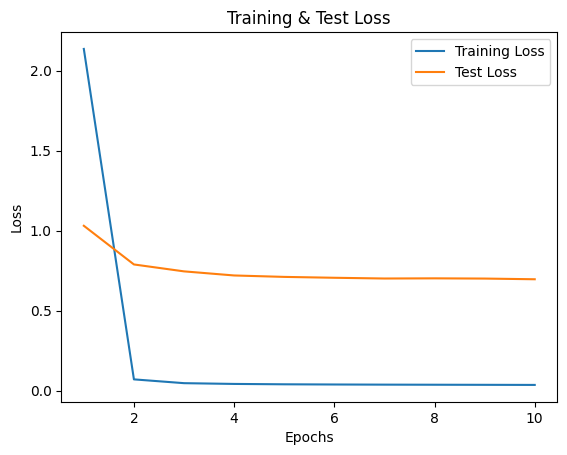

In [23]:
t5_train_stats = train_and_evaluate(
    model=t5_model,
    optimizer=t5_optimizer,
    device=t5_device,
    train_loader=t5_loaders["train_loader"],
    test_loader=t5_loaders["test_loader"],
    epochs=10,
    accumulation_steps=4
)

### IV.C.5. PEGASUS Model Training

Epoch 1:   0%|          | 0/1991 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: nan
Epoch 1 | Test Loss: 5.617654122195198


Epoch 2:   0%|          | 0/1991 [00:00<?, ?it/s]

Epoch 2 | Average Training Loss: 0.5779281088681016
Epoch 2 | Test Loss: 0.7648357975878376


Epoch 3:   0%|          | 0/1991 [00:00<?, ?it/s]

Epoch 3 | Average Training Loss: 0.04179620268997432
Epoch 3 | Test Loss: 0.607874519279088


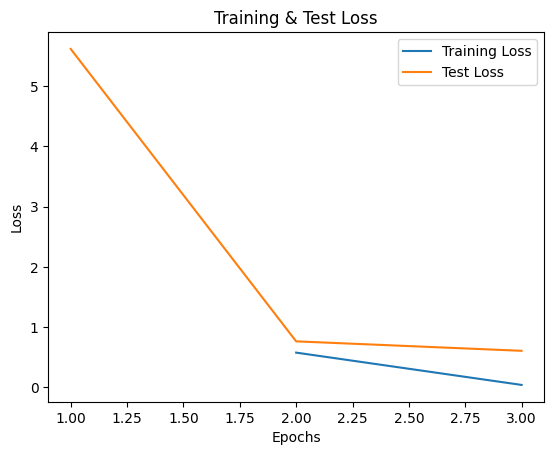

In [24]:
pegasus_train_stats = train_and_evaluate(
    model=pegasus_model,
    optimizer=pegasus_optimizer,
    device=pegasus_device,
    train_loader=pegasus_loaders["train_loader"],
    test_loader=pegasus_loaders["test_loader"],
    epochs=3,
    accumulation_steps=4
)

## IV.D. Models Selection

### IV.D.1. Baseline Model Performance Review

In [25]:
def evaluate_summarization_model(model, model_name, tokenizer, train_loader, test_loader, val_loader, device):
    model.eval()
    rouge = evaluate.load('rouge')
    data_loaders = {"train": train_loader, "test": test_loader, "validation": val_loader}
    results = []
    for key, data_loader in data_loaders.items():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            with torch.no_grad():
                outputs = model.generate(input_ids=input_ids, max_length=200, min_length=30, num_beams=1)
            pred_summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            true_summaries = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
            rouge.add_batch(predictions=pred_summaries, references=true_summaries)
        final_scores = rouge.compute()
        result = {
            metric: score * 100 for metric,
            score in final_scores.items()
        }
        result["model"] = model_name
        result["dataset"] = key
        results.append(result)
    return pd.DataFrame(results)


def visualize_rouge_scores(df):
    df_melted = df.melt(id_vars=["model", "dataset"], var_name="metric", value_name="score")
    barplot = sns.barplot(
        x="metric",
        y="score",
        hue="dataset",
        data=df_melted,
        palette="muted",
        errorbar=None
    )
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.2f', label_type='center', rotation=90)
    plt.title("ROUGE Scores for Summarization Model")
    plt.xlabel("ROUGE Metric")
    plt.ylabel("Score")
    plt.legend(title="Dataset")
    plt.show()

In [26]:
t5_results = evaluate_summarization_model(
    model=t5_model, 
    model_name="T5", 
    tokenizer=t5_tokenizer, 
    train_loader=t5_loaders["train_loader"],
    test_loader=t5_loaders["test_loader"],
    val_loader=t5_loaders["validation_loader"], 
    device=t5_device
)

In [27]:
t5_results

,rouge1,rouge2,rougeL,rougeLsum,model,dataset
0,32.882609,15.945740,27.963079,27.944707,T5,train
1,29.008144,10.980509,21.184833,21.190013,T5,test
2,30.893467,12.661106,23.637364,23.634720,T5,validation


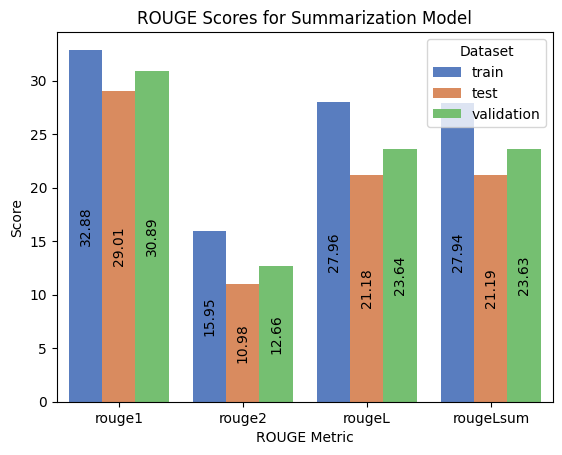

In [28]:
visualize_rouge_scores(t5_results)

In [31]:
pegasus_results = evaluate_summarization_model(
    model=pegasus_model, 
    model_name="PEGASUS", 
    tokenizer=pegasus_tokenizer, 
    train_loader=pegasus_loaders["train_loader"], 
    val_loader=pegasus_loaders["validation_loader"], 
    test_loader=pegasus_loaders["test_loader"], 
    device=pegasus_device
)

C:\Users\harde\anaconda3\envs\pacmann_nlp\Lib\site-packages\transformers\generation\configuration_utils.py:472: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.6` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


In [32]:
pegasus_results

,rouge1,rouge2,rougeL,rougeLsum,model,dataset
0,31.031001,14.112605,25.723476,25.724969,PEGASUS,train
1,30.440397,10.343988,21.171158,21.204578,PEGASUS,test
2,32.089716,12.100369,23.512647,23.492167,PEGASUS,validation


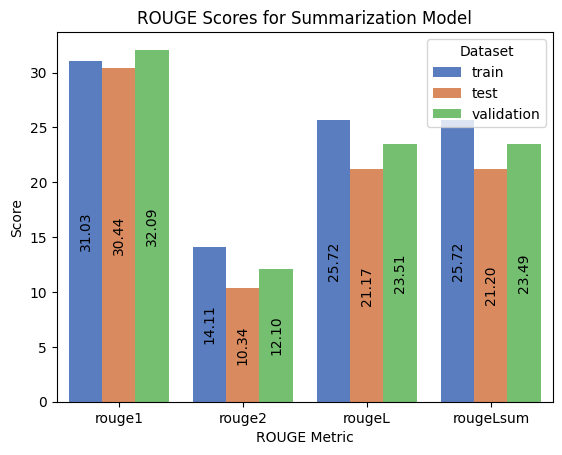

In [33]:
visualize_rouge_scores(pegasus_results)

### IV.D.2. Export Baseline Best Model

In [30]:
t5_save_directory = '../../models/t5_model'
t5_model.save_pretrained(t5_save_directory)
t5_tokenizer.save_pretrained(t5_save_directory)

pegasus_save_directory = '../../models/pegasus_model'
pegasus_model.save_pretrained(pegasus_save_directory)
pegasus_tokenizer.save_pretrained(pegasus_save_directory)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6, 'forced_eos_token_id': 1}


('../../models/pegasus_model\\tokenizer_config.json',
 '../../models/pegasus_model\\special_tokens_map.json',
 '../../models/pegasus_model\\spiece.model',
 '../../models/pegasus_model\\added_tokens.json')